In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
pollution_meteo = pd.read_csv("output/pollution_meteo_clean.csv")
pollution_meteo["timestamp"] = pd.to_datetime(pollution_meteo["timestamp"])

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_6192\1331148009.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df00["date"] = df00["timestamp"].dt.date
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_6192\1331148009.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df10["season"] = df10["timestamp"].dt.month % 12 // 3
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_6192\1331148009.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

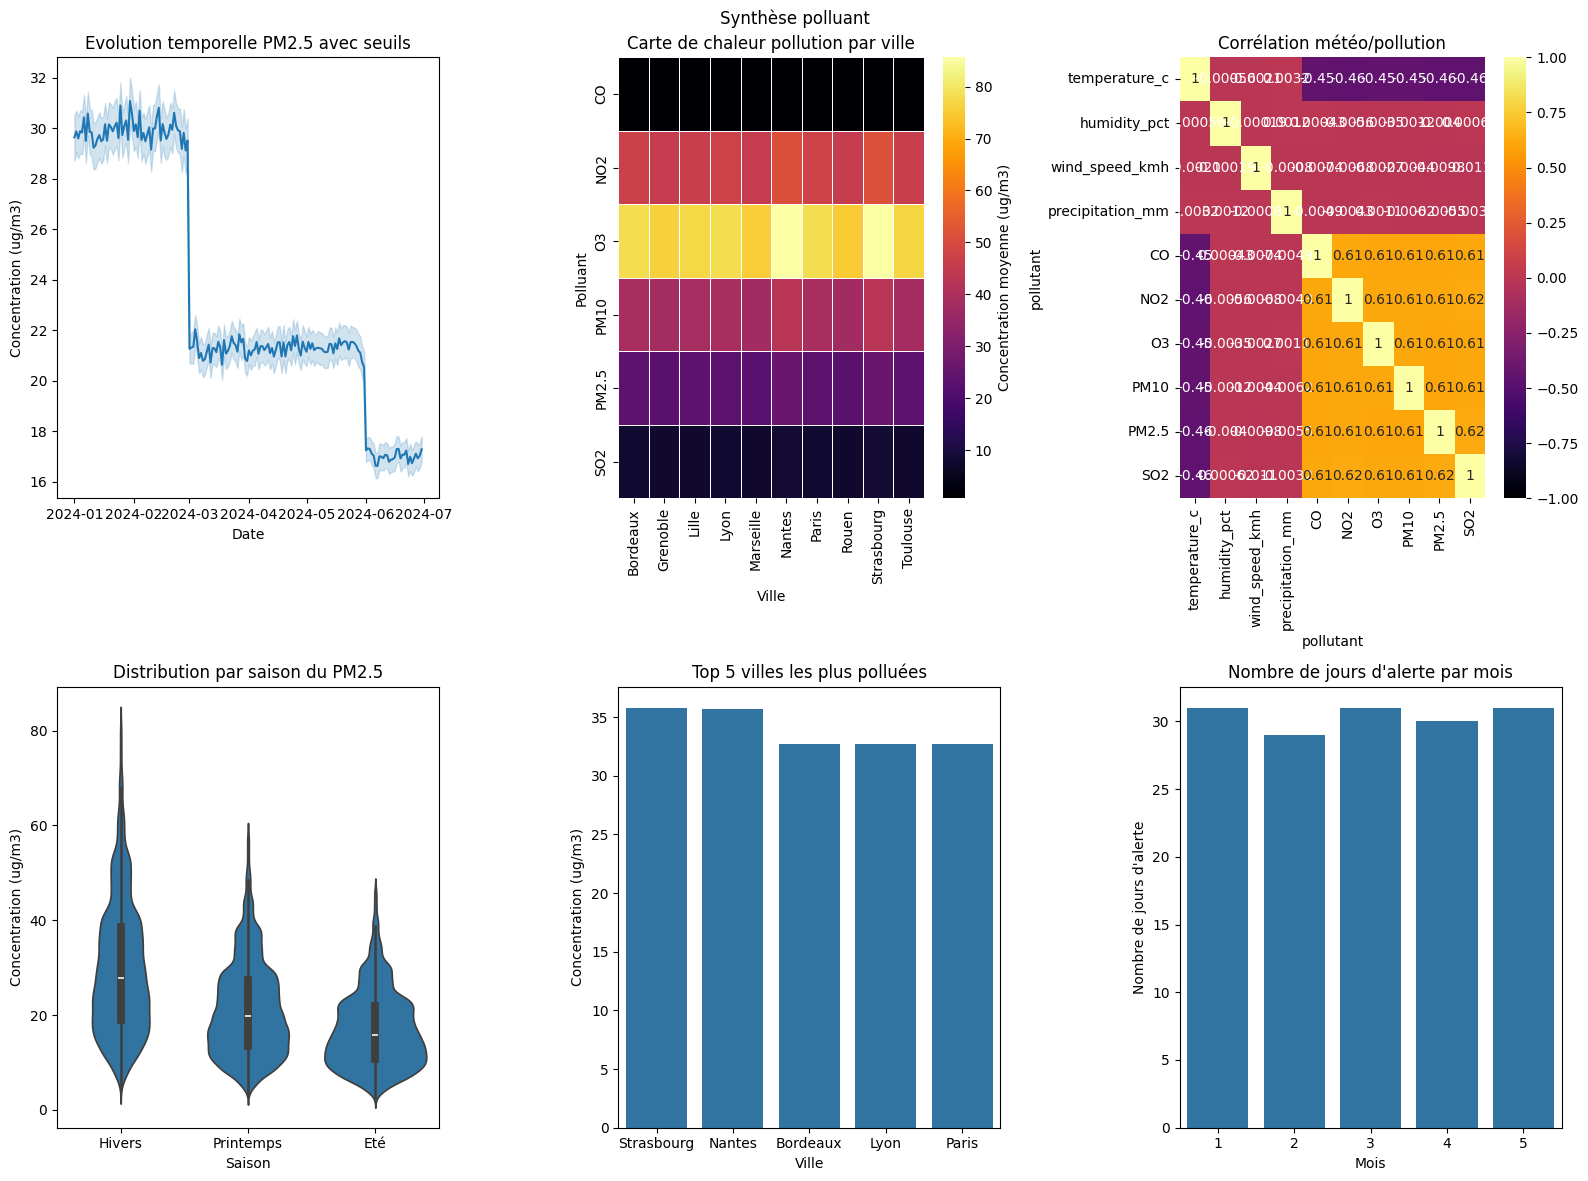

In [29]:
# Créer une figure multi-panneaux (2x3) synthétisant les insights :
# - Panel 1 : Evolution temporelle PM2.5 avec seuils
# - Panel 2 : Carte de chaleur pollution par ville
# - Panel 3 : Corrélation météo/pollution
# - Panel 4 : Distribution par saison
# - Panel 5 : Top 5 villes les plus polluées
# - Panel 6 : Nombre de jours d'alerte par mois
df00 = pollution_meteo[pollution_meteo["pollutant"] == "PM2.5"]
df00["date"] = df00["timestamp"].dt.date

df01 = pollution_meteo.pivot_table(
    values="value",
    index="pollutant",
    columns="city",
    aggfunc="mean"
)

df02 = pollution_meteo.pivot_table(
    index=["temperature_c", "humidity_pct", "wind_speed_kmh", "precipitation_mm"],
    columns="pollutant",
    values="value"
).reset_index()
corr02 = df02.corr(
    method="spearman",
    numeric_only=True
)

df10 = pollution_meteo[pollution_meteo["pollutant"] == "PM2.5"]
df10["season"] = df10["timestamp"].dt.month % 12 // 3

df11 = pollution_meteo.groupby("city").agg(mean_value=("value", "mean")).nlargest(5, "mean_value")

query_alert = '(pollutant == "PM2.5" and value > 50) or (pollutant == "PM10" and value > 80) or (pollutant == "NO2" and value > 400) or (pollutant == "O3" and value > 240) or (pollutant == "SO2" and value > 500)'
df12 = pollution_meteo.query(query_alert)
df12["month"] = df12["timestamp"].dt.month
df12["day"] = df12["timestamp"].dt.day
df12 = df12.groupby(["month", "day"]).agg(total=("value", "sum")).groupby("month").agg(total_day=("total", "count"))

fig, axes = plt.subplots(2,3, figsize=(16,12))
fig.suptitle("Synthèse polluant")

sns.lineplot(df00, x="date", y="value", ax=axes[0,0])
axes[0,0].set_title("Evolution temporelle PM2.5 avec seuils")
axes[0,0].set_xlabel("Date")
axes[0,0].set_ylabel("Concentration (ug/m3)")

sns.heatmap(
    df01,
    cmap="inferno", 
    linewidths=0.5,
    cbar_kws={'label': 'Concentration moyenne (ug/m3)'},
    ax=axes[0,1]
)
axes[0,1].set_title("Carte de chaleur pollution par ville")
axes[0,1].set_xlabel("Ville")
axes[0,1].set_ylabel("Polluant")

sns.heatmap(corr02, annot=True, cmap='inferno', vmin=-1, vmax=1, ax=axes[0,2])
axes[0,2].set_title("Corrélation météo/pollution")

sns.violinplot(df10, x="season", y="value", ax=axes[1,0])
axes[1,0].set_title("Distribution par saison du PM2.5")
axes[1,0].set_xlabel("Saison")
axes[1,0].set_ylabel("Concentration (ug/m3)")
axes[1,0].set_xticks(np.arange(3), labels=["Hivers", "Printemps", "Eté"])

sns.barplot(
    df11,
    x="city",
    y="mean_value",
    ax=axes[1,1]
)
axes[1,1].set_title("Top 5 villes les plus polluées")
axes[1,1].set_xlabel("Ville")
axes[1,1].set_ylabel("Concentration (ug/m3)")

sns.barplot(
    df12,
    x="month",
    y="total_day",
    ax=axes[1,2]
)
axes[1,2].set_title("Nombre de jours d'alerte par mois")
axes[1,2].set_xlabel("Mois")
axes[1,2].set_ylabel("Nombre de jours d'alerte")

plt.tight_layout()

plt.savefig("output/figures/dashboard_qualite_air.png")

2. Rédiger un résumé des conclusions (10-15 lignes).

La pollution semble corrélée à la saisonnalité. La concentration de polluant est plus forte en hivers et moins forte en été.
Quelque doit la ville, le polluant ayant la plus grande concentration moyenne est l'ozone.
La température semble sorrélée à la concentration de polluant. Les concentrations de polluant semblent corrélées entre elles.
En moyenne, les villes ayant la plus grande concentration de polluant sont Strasbourg et Nantes.
Le nombre d'alerte est le plus grand en janvier et février.